# Thinkful Data Science Capstone Final Project 

### Roy Shabaya

# Overview

For my final project I will be building a recommender system for an online retailer.  The overall problem I am attempting to solve is to be able to provide meaningful and high quality recommendations to customers.  The dataset is downloaded from UCI’s Machine Learning Repository and contains transaction data from an online retailer based in the UK.  The retailer sells gift items across several countries in Europe.  Contained in the data is information on each transaction, including the customer and product purchased.  In such a setting a recommender system can allow a retailer to provide quality recommendations to the customer that can result in increased sales and customer satisfaction.  

Data Source : https://archive.ics.uci.edu/ml/datasets/Online+Retail
<a id='index_link'></a>

## Index

[Data Import and Exploration Pre-Processing](#Data)

[Exploration](#exploration_link)

   - [Time](#time_link)
   - [Customer](#customer_link)
   - [Transaction](#transaction_link)
   - [Product](#product_link)
   
[Text Cleaning and NLP Pre-Processing](#cleaning_link)
   
[Modeling](#modeling_link) 
 
   - [Similarity](#similarity_link)
   
       - [Doc2vec](#doc2vec_link)
       - [TFIDF/Cosine Similarity](#tfidf)
       
       
   - [Market Basket](#basket_link)

 
   
<a id='Data'></a>

## Data Import and Pre-processing

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import calendar

In [2]:
# Import data
data = pd.read_csv(r'C:\Users\shaba\Online Retail.csv')

In [3]:
# See columns and their data type information.  Date is an object, will need to be modified at least for time series
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [5]:
# See the first 5 rows of data
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
# Add a revenue column, multiplying quanity and unit price. Also exclude returns and focus on sales only
data = data.loc[(data['Quantity'] >0) & (data['UnitPrice'] >0)]
data["Revenue"] = data['Quantity'] * data['UnitPrice']

In [7]:
# Add several views of the date information, Day of Week, Hour, etc.
data['Day of Week'] = data["InvoiceDate"].dt.weekday_name
data['Week of Year'] = data["InvoiceDate"].dt.weekofyear
data['Week of Year'] = data["InvoiceDate"].dt.weekofyear
data['Month'] = data["InvoiceDate"].dt.month
data['Hour'] = data["InvoiceDate"].dt.hour
data['Year'] = data["InvoiceDate"].dt.year
data['Day of Week Number'] = data['InvoiceDate'].dt.weekday

In [8]:
# See head with additional columns added
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Day of Week,Week of Year,Month,Hour,Year,Day of Week Number
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,Wednesday,48,12,8,2010,2
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday,48,12,8,2010,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,Wednesday,48,12,8,2010,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday,48,12,8,2010,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday,48,12,8,2010,2


<a id='exploration_link'></a>

# Exploration
<a id='time_link'></a>
[Index](#index_link)


## Time Exploration

In [9]:
print("data start: {}".format(data.InvoiceDate.min()))
print("data end: {}".format(data.InvoiceDate.max()))

data start: 2010-12-01 08:26:00
data end: 2011-12-09 12:50:00


In [10]:
#Regroup sales transactions
twelve_month_data = data.loc[data['InvoiceDate'] < '2011-12-01']
sales_time_grouped = data.groupby(['InvoiceNo','Day of Week','Week of Year','Month',"Hour",'Year','Day of Week Number'], as_index=False)['Quantity','Revenue'].sum()
sales_time_grouped_12 = twelve_month_data.groupby(['InvoiceNo','Day of Week','Week of Year','Month',"Hour",'Year','Day of Week Number'], as_index=False)['Quantity','Revenue'].sum()
sales_dow_grouped = data.groupby(['InvoiceNo','Day of Week Number','Day of Week'], as_index=False)['Quantity','Revenue'].sum()
time_grouped_75_revenue = sales_dow_grouped.loc[sales_time_grouped["Revenue"] < sales_dow_grouped.Revenue.quantile(.75)]
time_grouped_75_quantity = sales_time_grouped.loc[sales_time_grouped["Quantity"] < sales_time_grouped.Revenue.quantile(.75)]
time_grouped_75_quantity_12 = sales_time_grouped_12.loc[sales_time_grouped["Quantity"] < sales_time_grouped_12.Revenue.quantile(.75)]


#time_grouped_75_quantity = sales_time_grouped.loc[sales_time_grouped["Quantity"] < sales_time_grouped.Quantity.quantile(.75)]

dow_grouped_75_quantity = time_grouped_75_quantity.groupby(['Day of Week Number','Day of Week'], as_index=False)['Quantity'].sum()

woy_grouped_75_quantity = time_grouped_75_quantity_12.groupby(['Week of Year'], as_index=False)['Quantity'].sum()

hour_grouped_75_quantity = time_grouped_75_quantity.groupby(['Hour'], as_index=False)['Quantity'].sum()

year_grouped_75_quantity = time_grouped_75_quantity.groupby(['Year'], as_index=False)['Quantity'].sum()

month_grouped_75_quantity = time_grouped_75_quantity_12.groupby(['Month'], as_index=False)['Quantity'].sum()
#time_grouped_75_revenue = sales_time_grouped.loc[sales_trans_grou#

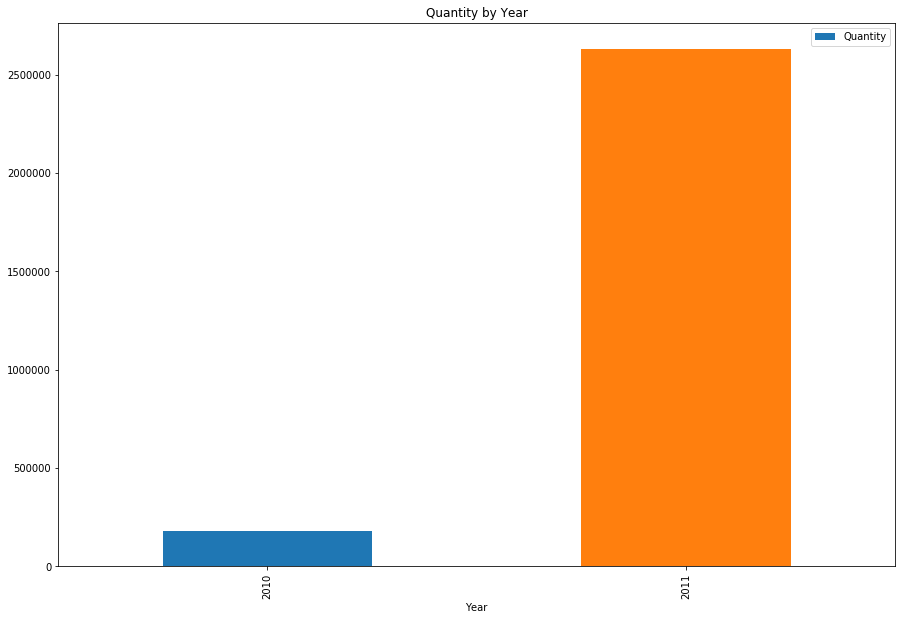

In [11]:
year_grouped_75_quantity.plot(x="Year", y='Quantity', kind='bar', figsize=(15,10))
plt.title('Quantity by Year')
plt.show()

It looks like there are only a few days in December 2019 included.  Will exclude December 2011 from the time exploration, will still have a few 12 months of data.

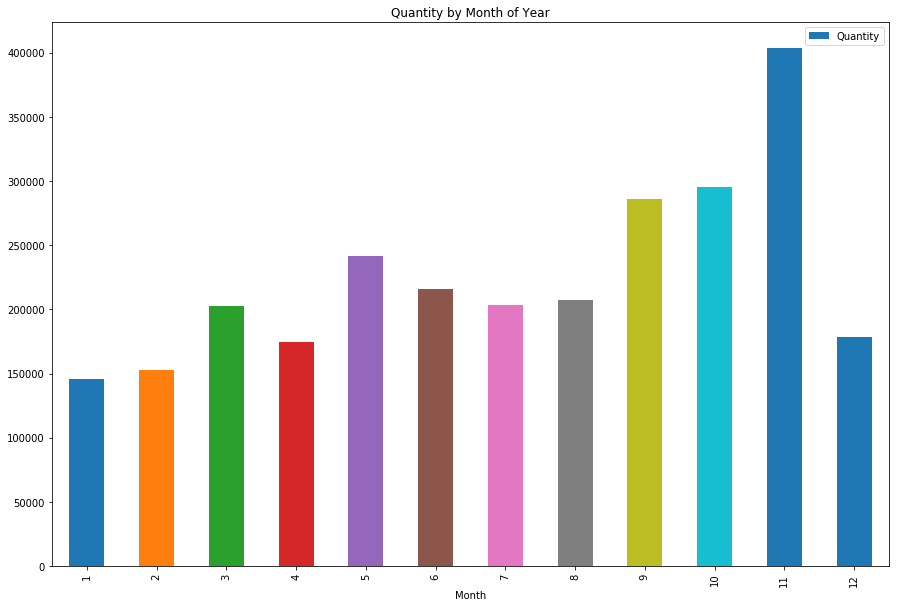

In [12]:
month_grouped_75_quantity.plot(x="Month", y='Quantity', kind='bar', figsize=(15,10))
plt.title('Quantity by Month of Year')
plt.show()

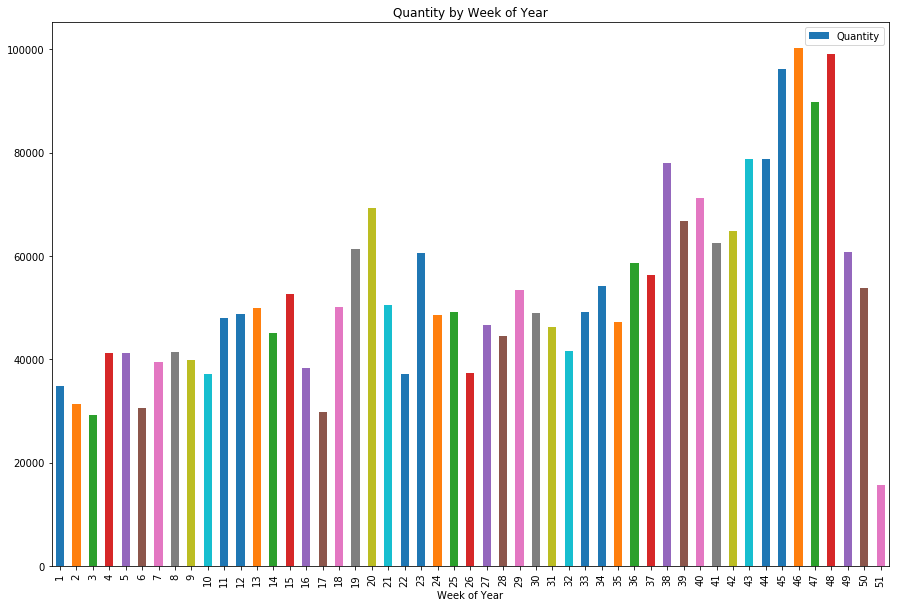

In [13]:
woy_grouped_75_quantity.plot(x="Week of Year", y='Quantity', kind='bar', figsize=(15,10))
plt.title('Quantity by Week of Year')
plt.show()

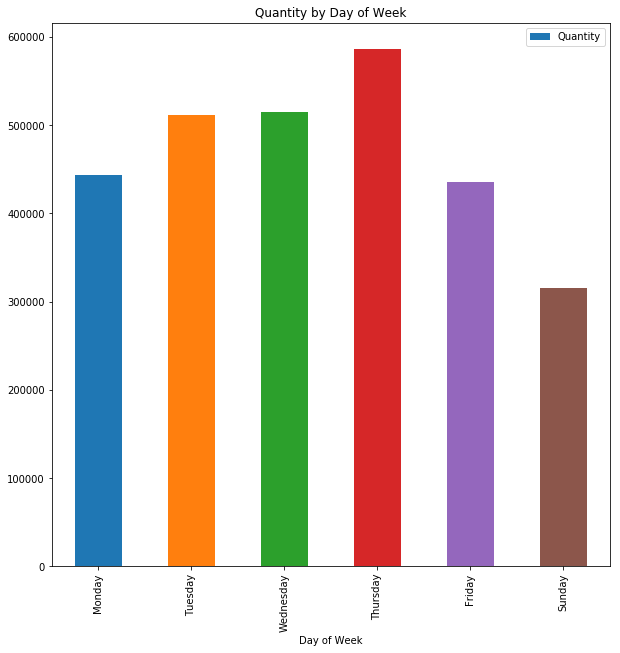

In [14]:
dow_grouped_75_quantity.plot(x="Day of Week", y='Quantity', kind='bar', figsize=(10,10))
plt.title('Quantity by Day of Week')
plt.show()

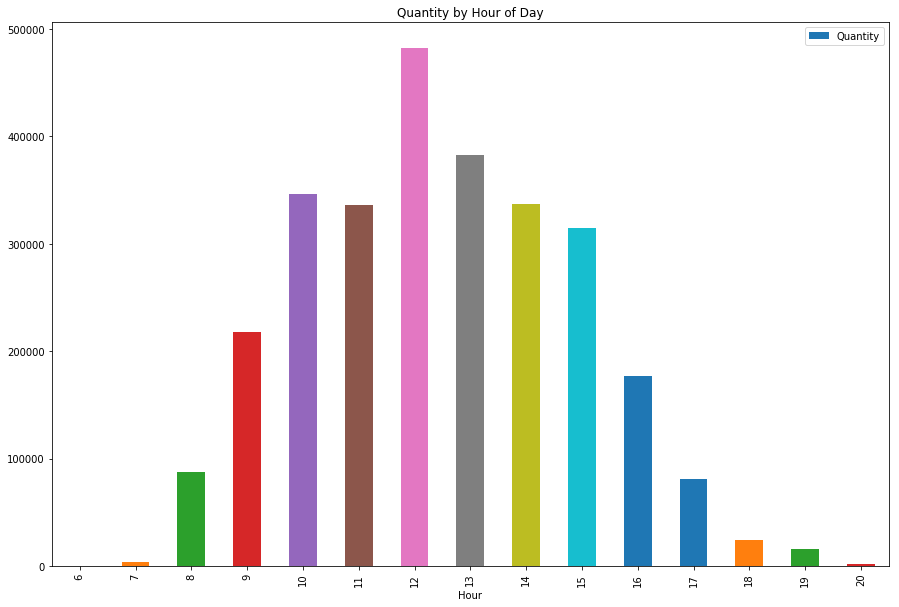

In [15]:
hour_grouped_75_quantity.plot(x="Hour", y='Quantity', kind='bar', figsize=(15,10))
plt.title('Quantity by Hour of Day')
plt.show()

<a id='customer_link'></a>

## Customer Exploration
[Index](#index_link)


In [16]:
#Regroup data at the customer level
sales_cust_grouped = data.groupby('CustomerID')['Quantity','Revenue'].sum()
sales_cust_grouped['ASP'] = sales_cust_grouped["Revenue"]/ sales_cust_grouped['Quantity']
print('Number of Customers: {}'.format(len(sales_cust_grouped)))

Number of Customers: 4338


In [17]:
# Descriptive statistics for the customer level data
sales_cust_grouped.describe()

,Quantity,Revenue,ASP
count,4338.000000,4338.000000,4338.000000
mean,1191.289073,2054.266460,3.013989
std,5046.081546,8989.230441,33.218307
min,1.000000,3.750000,0.085619
25%,160.000000,307.415000,1.408745
50%,379.000000,674.485000,1.808724
75%,992.750000,1661.740000,2.351760
max,196915.000000,280206.020000,2033.100000


In [18]:
sales_cust_grouped = sales_cust_grouped.sort_values(by='Quantity', ascending=False)
top_10_customers = sales_cust_grouped.head(10).reset_index()
top_10_customers = top_10_customers.sort_values(by="Quantity", ascending=True)

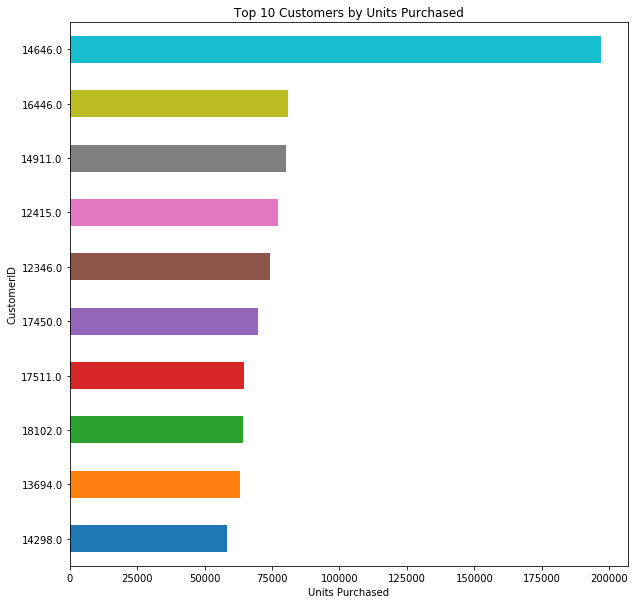

In [19]:
ax = top_10_customers.plot(x='CustomerID',y='Quantity', kind='barh', figsize=(10,10), legend=False)
ax.set_xlabel("Units Purchased")
plt.title("Top 10 Customers by Units Purchased")
plt.show()

First, we can see there are 4,318 customers. There are interesting gaps in the customers looking at the revenue alone.  The average customer has spent 1,1815, the smallest 2.90 and the biggest over 234,407.  It appears they have some large customers, but also service small customers as well.  The gaps in quantity are also similar, with the biggest customers purchasing over 156,113 units, versus a mean of 1,001 and 75th percentile of 939. Let's look at boxplots for ASP, Quanity and Revenue at the customer level.

We see there is a very large unit customers at 175,000 with the next customer at less than half that amount just above 75,000.  Let's look at how this is shown when we look at revenue.

Again, we see the very large customer with close to 250,000 in revenue.  It is interesting to note there are quite a few customers between 50,000 to 150,000.  And a bigger cluster in the lower thousands up to 50,000. Lets try to remove some of the larger customers by limiting units to the 75th percentile.  This should help us have a better understanding of the majority of the customers.

In [20]:
sales_cust_grouped.head()

,Quantity,Revenue,ASP
CustomerID,,,
14646.0,196915,280206.02,1.422980
16446.0,80997,168472.50,2.079984
14911.0,80265,143825.06,1.791878
12415.0,77374,124914.53,1.614425
12346.0,74215,77183.60,1.040000


In [21]:
# Limit sales customer grouping to 940 units, 939 units is the 75th percentile.
sales_cust_grouped_75_qty = sales_cust_grouped.loc[sales_cust_grouped['Quantity'] < sales_cust_grouped.Quantity.quantile(.75)]
sales_cust_grouped_75_revenue = sales_cust_grouped.loc[sales_cust_grouped['Revenue'] < sales_cust_grouped.Revenue.quantile(.75)]

When we exclude some of the bigger customers we are still left from 3,237 customers, from our previous total of 4,318.  Interestingly this caps are biggest customer at 39,917 in revenue.  The average units ordered are 313 and 610 in revenue.  Let's look at histograms for distributions of these customers.

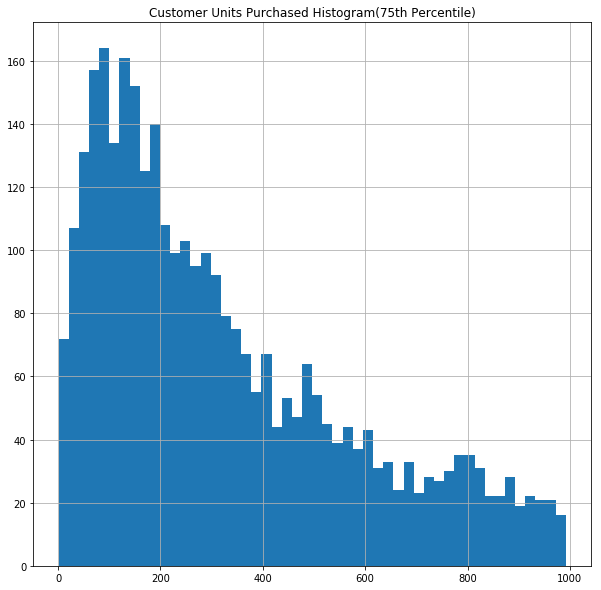

In [22]:
sales_cust_grouped_75_qty.hist(column='Quantity', bins=50, figsize=(10,10))
plt.title('Customer Units Purchased Histogram(75th Percentile)')
plt.show()

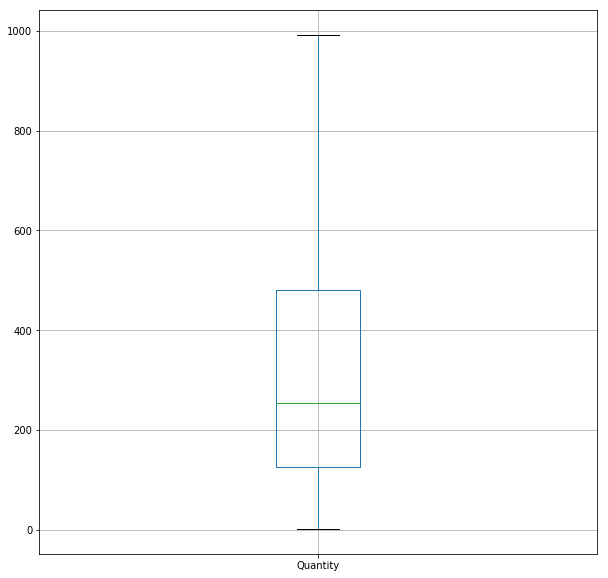

In [23]:
sales_cust_grouped_75_qty.boxplot(column='Quantity', figsize=(10,10))
plt.show()

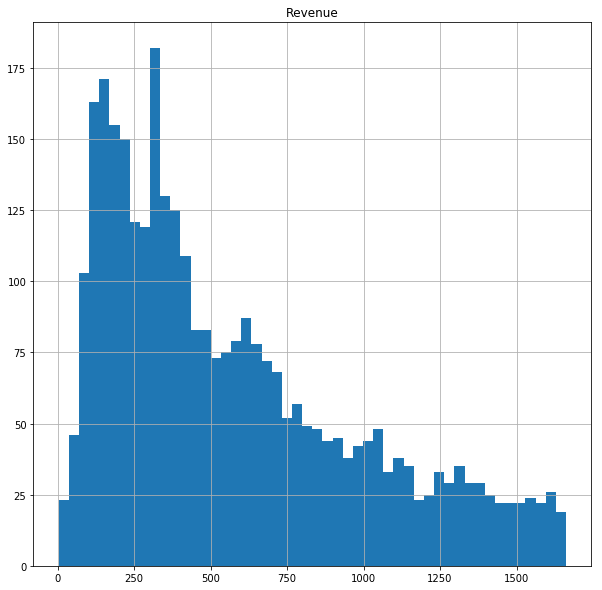

In [24]:
sales_cust_grouped_75_revenue.hist(column='Revenue', bins=50, figsize=(10,10))
plt.show()

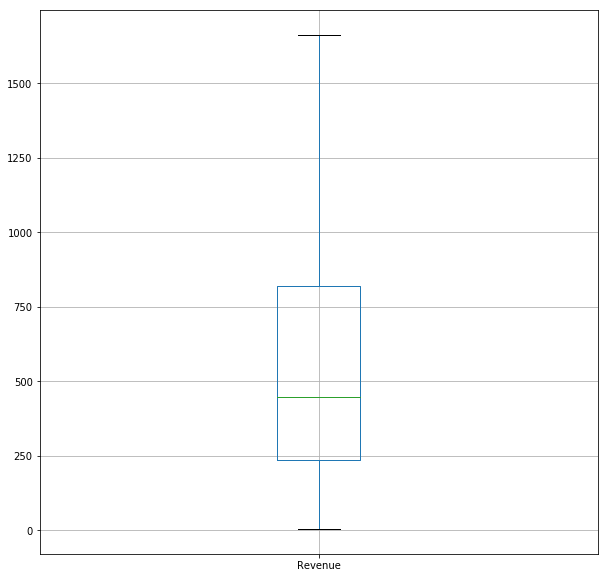

In [25]:
sales_cust_grouped_75_revenue.boxplot(column='Revenue', figsize=(10,10))
plt.show()

<a id='transaction_link'></a>

## Transaction Exploration
[Index](#index_link)


In [26]:
#Regroup sales transactions
sales_trans_grouped = data.groupby('InvoiceNo')['Quantity','Revenue'].sum()
sales_trans_grouped['ASP'] = sales_trans_grouped["Revenue"]/ sales_trans_grouped['Quantity']

trans_grouped_75_quantity = sales_trans_grouped.loc[sales_trans_grouped["Quantity"] < sales_trans_grouped.Quantity.quantile(.75)]
trans_grouped_75_revenue = sales_trans_grouped.loc[sales_trans_grouped["Revenue"] < sales_trans_grouped.Revenue.quantile(.75)]

In [27]:
# Look at number of transactions
print('Number of transactions: {}'.format(len(sales_trans_grouped)))
print('Total Revenue: {}'.format(sum(sales_trans_grouped['Revenue'])))
print('Total Units: {}'.format(sum(sales_trans_grouped['Quantity'])))

Number of transactions: 19960
Total Revenue: 10666684.544000056
Total Units: 5588376


In [28]:
sales_trans_quantity_75 = sales_trans_grouped.loc[sales_trans_grouped['Quantity'] < sales_trans_grouped.Quantity.quantile(.75)]
sales_trans_revenue_75 = sales_trans_grouped.loc[(sales_trans_grouped['Revenue'] < sales_trans_grouped.Revenue.quantile(.75)) & (sales_trans_grouped['Revenue'] >0)]

When we focus on sales transactions only that reduces our transaction count from 25,900 to 20,496.  Still a good number of transactions for analysis.  Next let's look at the descriptive statistics for this reduced group.>

In [29]:
sales_trans_grouped.describe()

,Quantity,Revenue,ASP
count,19960.000000,19960.000000,19960.000000
mean,279.978758,534.403033,7.735306
std,955.324779,1780.487648,159.132388
min,1.000000,0.380000,0.060000
25%,70.000000,152.510000,1.424549
50%,151.000000,303.835000,1.946812
75%,296.000000,495.615000,2.816500
max,80995.000000,168469.600000,13541.330000


For sales transactions it looks like the average revenue is 465, with 232 units and ASP of 6.21.  Based on that ASP it looks like most of the items they sell are of a lower dollar value.  The 75% percentile for ASP reinforces that as it's only 2.78.  But based on the max of 13,541 it looks like there are some transactions with individual products that are very highly priced. We'll have ot look for more detail on those higher priced items later and see if they are valid o be included. Next lets look at histograms to see distribution for ASP, Quantity and Revenue.

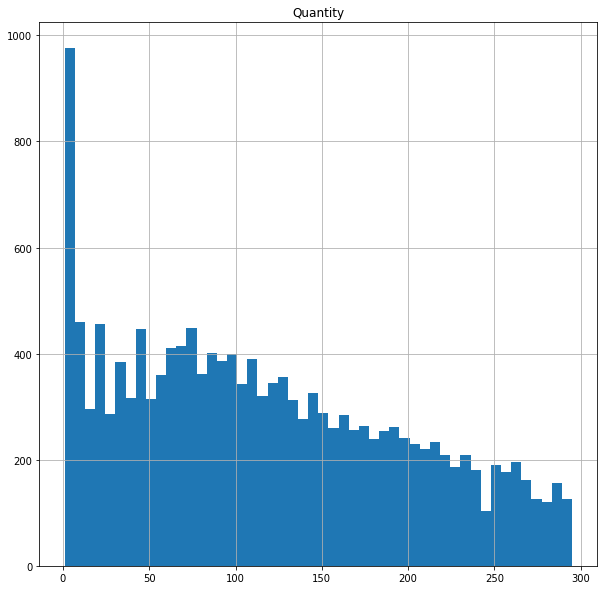

In [30]:
trans_grouped_75_quantity.hist(column='Quantity',bins=50, figsize=(10,10))
plt.show()

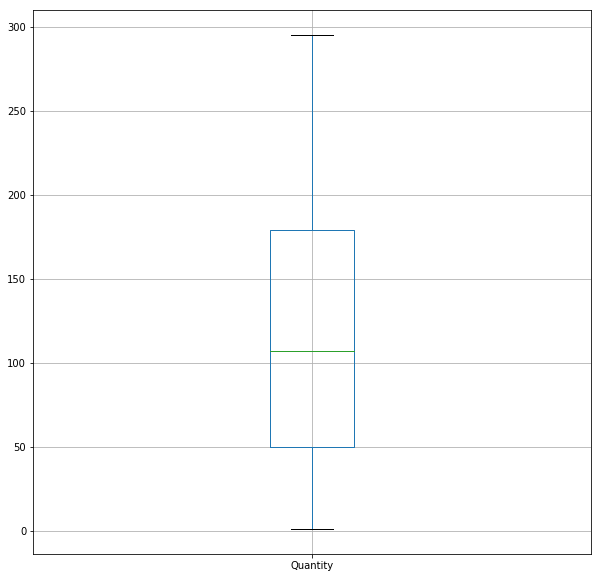

In [31]:
trans_grouped_75_quantity.boxplot(column='Quantity', figsize=(10,10))
plt.show()

The histograms reinforce what we saw with the descriptive statistics, most transactions are at the lower end of Revenue, ASP and Quantity.  Let's look at boxplots for a different view of the distributions of Quantity and Revenue.

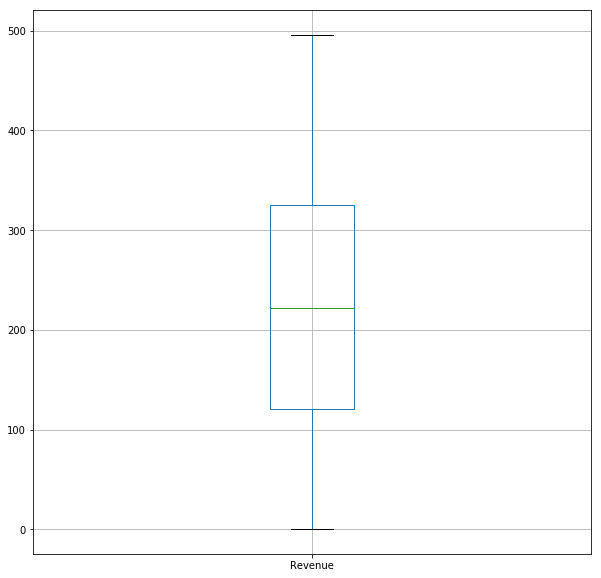

In [32]:
sales_trans_revenue_75.boxplot(column='Revenue', figsize=(10,10))
plt.show()

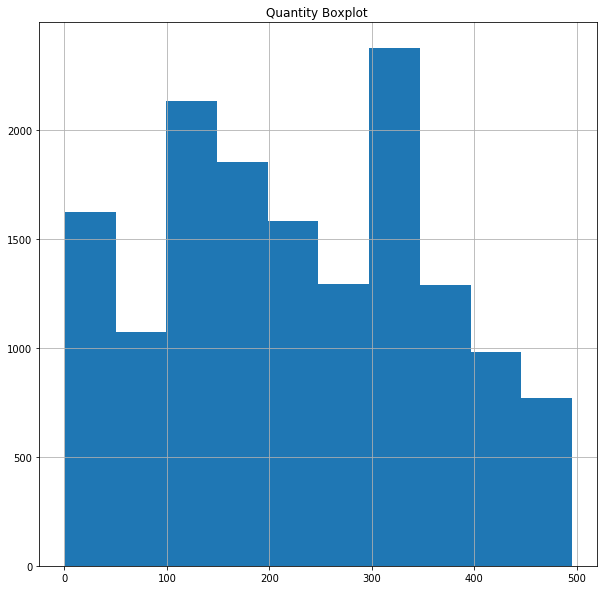

In [33]:
trans_grouped_75_revenue.hist(column='Revenue', figsize=(10,10))
plt.title('Quantity Boxplot ')
plt.show()

The box plots alighn with everything we've seen in regards to individual transactions.  Now that we have a general idea about those, let's look at the data form a customer perspective.
<a id='product_link'></a>

## Product Exploration
[Index](#index_link)


To begin the exploration let's look at the data at the product level.  It will be important to learn how many product there are as well as learn about the differences in revenue and quantity of each product.

In [34]:
# Group data by transactions with Revenue and Quantity columns
product_grouped = data.groupby(by='Description')['Quantity','Revenue'].sum()
product_grouped['ASP'] = product_grouped['Revenue'] / product_grouped['Quantity']
print('Number of Products: {}'.format(len(product_grouped)))

Number of Products: 4026


In [35]:
product_grouped.describe()

,Quantity,Revenue,ASP
count,4026.000000,4026.000000,4026.000000
mean,1388.071535,2649.449713,8.122115
std,3465.395806,7815.336619,205.624154
min,1.000000,0.003000,0.001000
25%,56.000000,126.757500,1.025689
50%,358.000000,666.900000,1.969831
75%,1372.750000,2190.140000,3.975347
max,80995.000000,206248.770000,11062.060000


In [36]:
# Group product and sort by revenue
product_grouped_revenue = product_grouped.sort_values(by="Revenue", ascending=False)
product_grouped_quantity = product_grouped.sort_values(by="Quantity", ascending=False)

In [37]:
product_grouped_quantity.describe()

,Quantity,Revenue,ASP
count,4026.000000,4026.000000,4026.000000
mean,1388.071535,2649.449713,8.122115
std,3465.395806,7815.336619,205.624154
min,1.000000,0.003000,0.001000
25%,56.000000,126.757500,1.025689
50%,358.000000,666.900000,1.969831
75%,1372.750000,2190.140000,3.975347
max,80995.000000,206248.770000,11062.060000


In [38]:
# Top 10 Quantity Products
product_grouped_quantity = product_grouped.sort_values(by="Quantity", ascending=False)
product_grouped_quantity.head(10)

,Quantity,Revenue,ASP
Description,,,
"PAPER CRAFT , LITTLE BIRDIE",80995,168469.60,2.080000
MEDIUM CERAMIC TOP STORAGE JAR,78033,81700.92,1.047005
WORLD WAR 2 GLIDERS ASSTD DESIGNS,55047,13841.85,0.251455
JUMBO BAG RED RETROSPOT,48474,94340.05,1.946199
WHITE HANGING HEART T-LIGHT HOLDER,37891,106292.77,2.805225
POPCORN HOLDER,36761,34298.87,0.933023
ASSORTED COLOUR BIRD ORNAMENT,36461,59094.93,1.620771
PACK OF 72 RETROSPOT CAKE CASES,36419,21259.10,0.583737
RABBIT NIGHT LIGHT,30788,66964.99,2.175035


In [39]:
top_10 = product_grouped_quantity.head(10).reset_index()

In [40]:
top_10 = top_10.sort_values(by='Quantity')

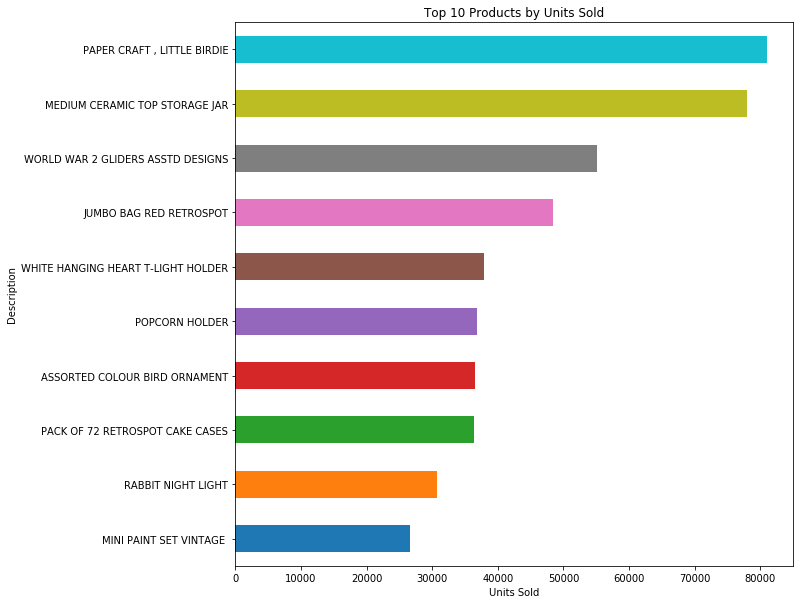

In [41]:
ax = top_10.plot(x='Description', y='Quantity', kind='barh', figsize=(10,10), legend=False)
ax.set_xlabel("Units Sold")
plt.title('Top 10 Products by Units Sold')
plt.show()

In [42]:
product_grouped.describe()

,Quantity,Revenue,ASP
count,4026.000000,4026.000000,4026.000000
mean,1388.071535,2649.449713,8.122115
std,3465.395806,7815.336619,205.624154
min,1.000000,0.003000,0.001000
25%,56.000000,126.757500,1.025689
50%,358.000000,666.900000,1.969831
75%,1372.750000,2190.140000,3.975347
max,80995.000000,206248.770000,11062.060000


In [43]:
# Look at 75th percentile of product to exclude large outliers
product_grouped_75_quantity = product_grouped.loc[product_grouped["Quantity"] < product_grouped.Quantity.quantile(.75)]
product_grouped_75_revenue = product_grouped.loc[product_grouped["Revenue"] < product_grouped.Revenue.quantile(.75)]

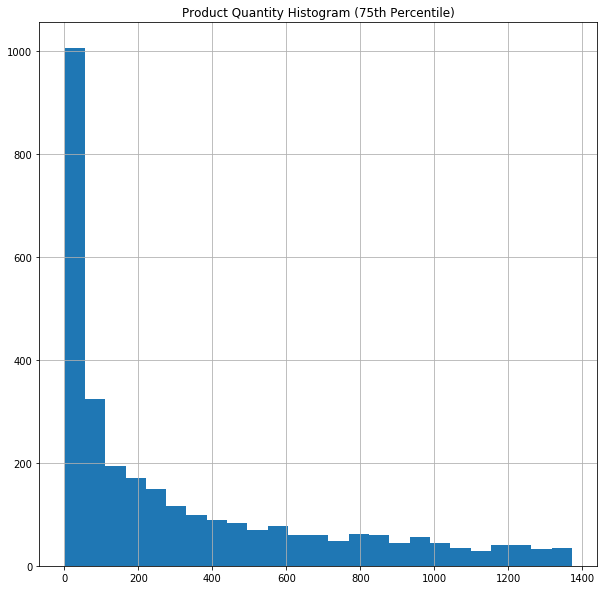

In [44]:
product_grouped_75_quantity.hist(column='Quantity', bins=25, figsize=(10,10))
plt.title('Product Quantity Histogram (75th Percentile)')
plt.show()

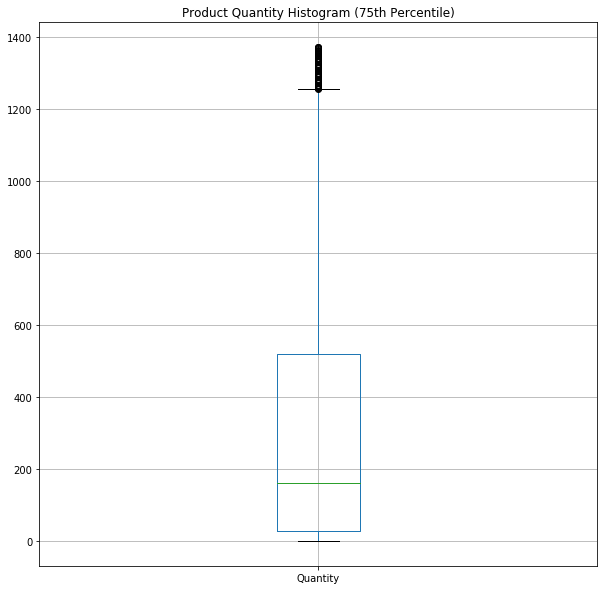

In [45]:
product_grouped_75_quantity.boxplot(column='Quantity', figsize=(10,10))
plt.title('Product Quantity Histogram (75th Percentile)')
plt.show()

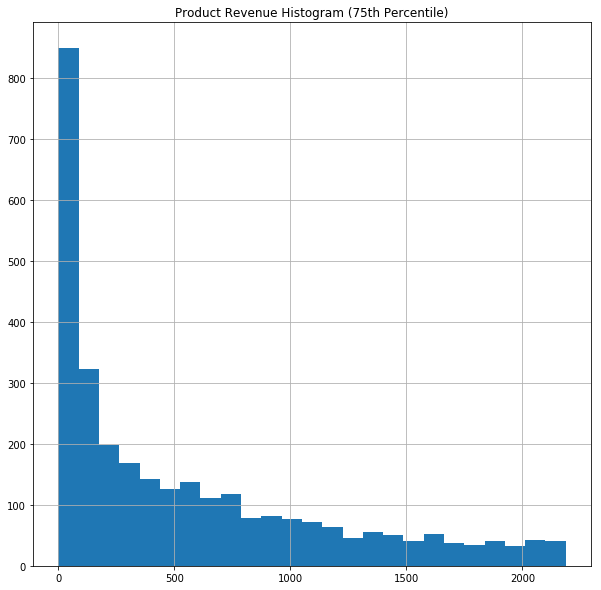

In [46]:
product_grouped_75_revenue.hist(column='Revenue', bins=25, figsize=(10,10))
plt.title('Product Revenue Histogram (75th Percentile)')
plt.show()

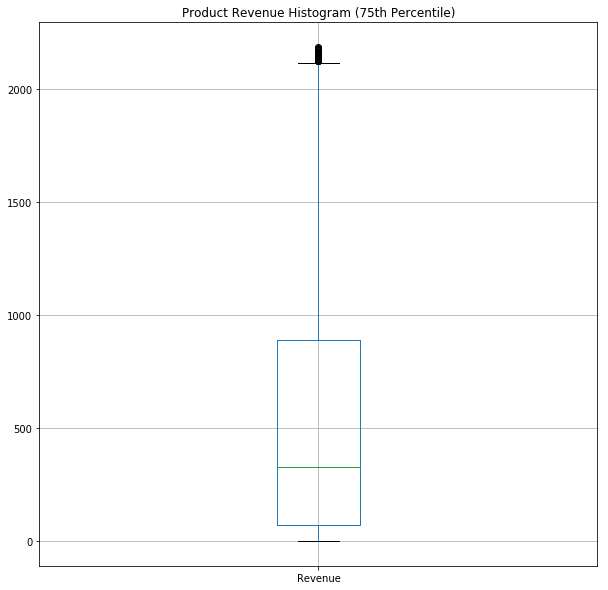

In [74]:
product_grouped_75_revenue.boxplot(column='Revenue', figsize=(10,10))
plt.title('Product Revenue Histogram (75th Percentile)')
plt.show()

In [48]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import calendar
import operator

from datetime import datetime, timedelta


import spacy
import re
from functools import reduce
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.metrics.pairwise import cosine_similarity

from sklearn import ensemble

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

import scipy
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_rows', 5000)

<a id='modeling_link'></a>

# Modeling
[Index](#index_link)
<a id='cleaning_link'></a>

## Text Cleaning and Preprocessing

In [49]:
# Separate product descriptions into dataframe for NLP
nlp_start_data = data["Description"].drop_duplicates()
nlp_doc_data = data["Description"]

In [50]:
# Text cleaning function

def text_cleaner(text):
    text = text.apply(lambda x:re.sub("\.", "", x))
    text = text.apply(lambda x:re.sub("\,", " ", x))
    text = text.apply(lambda x:re.sub("-", " ", x))
    text = text.apply(lambda x:re.sub("'","",x)) 
    text = text.apply(lambda x:re.sub("\"","",x)) 
    text = text.apply(lambda x:re.sub("  "," ",x)) 
    text = text.apply(lambda x:re.sub("\\\\","",x))  
    text = text.apply(lambda x:re.sub("/"," ",x))  
    text = text.apply(lambda x:re.sub("-", " ", x))
    text = text.apply(lambda x:re.sub("\+", " ", x))
    return text


In [51]:
# Clean text
cleaned_text=text_cleaner(nlp_start_data)
cleaned_document = text_cleaner(nlp_doc_data )
description_column =data["Description"]


## Similarity Models
<a id='similarity_link'></a>
<a id='tfidf'></a>

### TFIDF/Cosine Similiarity
[Index](#index_link)

In [52]:
# Initialize vectorizer to be used for cosine similarity

TFIDF_vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english', lowercase=True, use_idf=True, norm=u'l2', smooth_idf=True)


In [53]:
#Vectorizer fit and transform cleaned text
TFIDF_Cleaned_Text = TFIDF_vectorizer.fit_transform(cleaned_text)

#SVD to reduce features

SVD_Term = TruncatedSVD(1250)
svd_starter = make_pipeline(SVD_Term, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
tfidf_svd_vectors = svd_starter.fit_transform(TFIDF_Cleaned_Text)

# See amount of variance capture by reduced features.  Testing will need to reflect impact of adjusting this level.  Adjusted using SVD_Term
svd_variance_explained=SVD_Term.explained_variance_ratio_
variance_explained = svd_variance_explained.sum()
print("Variance Captured by Reduced Components:",variance_explained*100.00)

Variance Captured by Reduced Components: 100.0


In [54]:
#Create list of cleaned columns
columns_list =nlp_start_data.tolist()

In [55]:
# Generate cosine similarity data
cosine_similiarity_data = cosine_similarity(tfidf_svd_vectors)
cosine_df = pd.DataFrame(data=cosine_similiarity_data, index = cleaned_text)
cosine_df_stacked = cosine_df.stack()

In [56]:
def cosine_similarity_tool(target):
    lookup_target = cosine_df_stacked[target]
    lookup_target_sorted = lookup_target.sort_values(ascending=False).reset_index()
    print('Original     : {}'.format(target))
    print('First Match  : {}'.format(columns_list[lookup_target_sorted['index'][1]]))
    print('Second Match : {}'.format(columns_list[lookup_target_sorted['index'][2]]))
    print('Third Match  : {}'.format(columns_list[lookup_target_sorted['index'][3]]))
    print('Fourth Match : {}'.format(columns_list[lookup_target_sorted['index'][4]]))
    print('Fifth Match  : {}'.format(columns_list[lookup_target_sorted['index'][5]]))
    print('Sixth Match  : {}'.format(columns_list[lookup_target_sorted['index'][6]]))
    print('Sevent Match : {}'.format(columns_list[lookup_target_sorted['index'][7]]))
    print('Eight Match  : {}'.format(columns_list[lookup_target_sorted['index'][8]]))
    print('Ninth Match  : {}'.format(columns_list[lookup_target_sorted['index'][9]]))
    print('Tenth Match  : {}'.format(columns_list[lookup_target_sorted['index'][10]]))
    

In [57]:
cosine_similarity_tool('WHITE METAL LANTERN')

Original     : WHITE METAL LANTERN
First Match  : WHITE MOROCCAN METAL LANTERN
Second Match : HANGING METAL HEART LANTERN
Third Match  : HANGING METAL STAR LANTERN
Fourth Match : WHITE LOVEBIRD LANTERN
Fifth Match  : LANTERN CREAM GAZEBO 
Sixth Match  : WHITE WITH METAL BAG CHARM
Sevent Match : SMALL HANGING GLASS+ZINC LANTERN
Eight Match  : FRENCH CARRIAGE LANTERN
Ninth Match  : PAPER LANTERN 5 POINT STUDDED STAR
Tenth Match  : PAPER LANTERN 5 POINT SEQUIN STAR


In [58]:
cosine_similarity_tool('HAND WARMER OWL DESIGN')

Original     : HAND WARMER OWL DESIGN
First Match  : HI TEC ALPINE HAND WARMER
Second Match : HAND WARMER BIRD DESIGN
Third Match  : HAND WARMER SCOTTY DOG DESIGN
Fourth Match : HAND WARMER BABUSHKA DESIGN
Fifth Match  : HAND WARMER RED RETROSPOT
Sixth Match  : HAND WARMER RED LOVE HEART
Sevent Match : HAND WARMER UNION JACK
Eight Match  : HAND WARMER RED POLKA DOT
Ninth Match  : OWL DOORSTOP
Tenth Match  : SPACE OWL


In [59]:
cosine_similarity_tool('DRAWER KNOB CERAMIC IVORY')

Original     : DRAWER KNOB CERAMIC IVORY
First Match  : DRAWER KNOB CERAMIC RED
Second Match : DRAWER KNOB CERAMIC BLACK
Third Match  : BLUE SPOT CERAMIC DRAWER KNOB
Fourth Match : RED SPOT CERAMIC DRAWER KNOB
Fifth Match  : BLUE STRIPE CERAMIC DRAWER KNOB
Sixth Match  : RED STRIPE CERAMIC DRAWER KNOB
Sevent Match : WHITE SPOT BLUE CERAMIC DRAWER KNOB
Eight Match  : WHITE SPOT RED CERAMIC DRAWER KNOB
Ninth Match  : DRAWER KNOB CRACKLE GLAZE IVORY
Tenth Match  : DRAWER KNOB VINTAGE GLASS STAR


<a id='doc2vec_link'></a>

## Doc2vec Model
[Index](#index_link)


In [60]:
import gensim
import os
import collections
import smart_open
import random

C:\Users\shaba\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [61]:
def read_corpus(fname, tokens_only=False):
    f=fname
    for i, line in enumerate(f):
        if tokens_only:
            yield gensim.utils.simple_preprocess(line)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), [i])

In [62]:
train_corpus = list(read_corpus(cleaned_text))
test_corpus = list(read_corpus(cleaned_text, tokens_only=True))

In [63]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=500, min_count=20, epochs=500)

model.build_vocab(train_corpus)

In [64]:
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)
    
    second_ranks.append(sims[1])

In [65]:
print('Original ({}): «{}»\n'.format(doc_id, ' '.join(train_corpus[doc_id].words)))
print(u'SIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('First Match', 0), ('Second Match', 1), ('Third Match', 2) , ('Fourth Match', 3) , ('Fifth Match', 4), ('Sixth Match', 5), ('Seventh Match', 6), ('Eight Match', 7), ('Ninth Match', 8), ('Tenth Match', 9)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Original (4025): «paper craft little birdie»

SIMILAR DOCS PER MODEL Doc2Vec(dm/m,d500,n5,w5,mc20,s0.001,t3):

First Match (3406, 0.17452917993068695): «set of knick knack tins poppies»

Second Match (3524, 0.15547683835029602): «garage key fob»

Third Match (1832, 0.1544826328754425): «magnets pack of vintage labels»

Fourth Match (2439, 0.14917325973510742): «starfish soap dish»

Fifth Match (1013, 0.14390094578266144): «red retrospot round cake tins»

Sixth Match (3710, 0.13720464706420898): «enamel dinner plate pantry»

Seventh Match (576, 0.13338693976402283): «metal merry christmas wreath»

Eight Match (2253, 0.13198848068714142): «la palmiera tile hook»

Ninth Match (941, 0.1313069760799408): «turquoise glass tassle bag charm»

Tenth Match (2863, 0.12805919349193573): «silver lariat cm»



<a id='basket_link'></a>

## Market Basket
[Index](#index_link)


In [75]:
# Import additional packages
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [67]:
# Prep market basket data and remove postage from dataset 

basket_starter = data
basket_starter = basket_starter.loc[data['Description'] != 'POSTAGE']
basket_starter = basket_starter.loc[data['Description'] != 'DOTCOM POSTAGE']
basket_data = basket_starter.groupby(['InvoiceNo','Description']).Quantity.sum()
basket_data = basket_data.unstack(level=-1).fillna(0)


In [68]:
# Encoder to indicate prescence of product on invoice
def unit_encoder(target):
    if target != 0:
        return 1
    else:
        return 0

In [69]:
# Encode data and prep for apriori algorithim
basket_data = basket_data.applymap(unit_encoder)

In [70]:
# Create basket items and run apriori
basket_items = apriori(basket_data, min_support =0.01, use_colnames=True)
rules = association_rules(basket_items, metric ='lift', min_threshold=1)


In [71]:
rules = rules.sort_values(by="antecedents")
rules.head(200)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(JAM MAKING SET PRINTED),(6 RIBBONS RUSTIC CHARM),0.058439,0.048029,0.011869,0.203098,4.228694,0.009062,1.194591
2043,(JUMBO BAG PINK POLKADOT),"(JUMBO BAG OWLS, JUMBO BAG RED RETROSPOT)",0.061255,0.019664,0.010561,0.172414,8.767969,0.009357,1.184573
2044,(JUMBO BAG OWLS),"(JUMBO BAG PINK POLKADOT, JUMBO BAG RED RETROS...",0.033042,0.041491,0.010561,0.319635,7.703778,0.009190,1.408816
2045,(JUMBO BAG RED RETROSPOT),"(JUMBO BAG PINK POLKADOT, JUMBO BAG OWLS)",0.105059,0.014082,0.010561,0.100527,7.138822,0.009082,1.096106
2049,(JUMBO BAG RED RETROSPOT),"(JUMBO BAG WOODLAND ANIMALS, JUMBO BAG OWLS)",0.105059,0.014182,0.010209,0.097176,6.851919,0.008719,1.091926
2050,(JUMBO BAG WOODLAND ANIMALS),"(JUMBO BAG RED RETROSPOT, JUMBO BAG OWLS)",0.043402,0.019664,0.010209,0.235226,11.962233,0.009356,1.281864
2039,(JUMBO BAG APPLES),"(JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO STOR...",0.049185,0.026353,0.010310,0.209611,7.954035,0.009014,1.231859
2051,(JUMBO BAG OWLS),"(JUMBO BAG WOODLAND ANIMALS, JUMBO BAG RED RET...",0.033042,0.026906,0.010209,0.308980,11.483668,0.009320,1.408200
2056,(JUMBO BAG OWLS),"(JUMBO STORAGE BAG SUKI, JUMBO BAG RED RETROSPOT)",0.033042,0.036411,0.011617,0.351598,9.656323,0.010414,1.486098
2057,(JUMBO BAG RED RETROSPOT),"(JUMBO STORAGE BAG SUKI, JUMBO BAG OWLS)",0.105059,0.016043,0.011617,0.110579,6.892656,0.009932,1.106290


In [72]:
regency_teapot_rules = rules.loc[rules['antecedents'] == frozenset({'REGENCY TEAPOT ROSES '})]
regency_teapot_rules = regency_teapot_rules.sort_values(by='lift', ascending=False)


In [73]:
regency_teapot_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1464,(REGENCY TEAPOT ROSES ),(REGENCY SUGAR BOWL GREEN),0.020921,0.016194,0.011718,0.560096,34.586807,0.011379,2.236412
1462,(REGENCY TEAPOT ROSES ),(REGENCY MILK JUG PINK ),0.020921,0.016546,0.011366,0.543269,32.833937,0.011020,2.153247
1474,(REGENCY TEAPOT ROSES ),(REGENCY TEA PLATE ROSES ),0.020921,0.022380,0.010008,0.478365,21.374870,0.009540,1.874147
1478,(REGENCY TEAPOT ROSES ),(ROSES REGENCY TEACUP AND SAUCER ),0.020921,0.053561,0.011919,0.569712,10.636755,0.010799,2.199546
1443,(REGENCY TEAPOT ROSES ),(REGENCY CAKESTAND 3 TIER),0.020921,0.099980,0.011366,0.543269,5.433785,0.009274,1.970570
